In [3]:
import os
import torch
import botorch # library for Bayesian Optimisation research
from torch import nn # Neural Network Module
import pandas as pd
from pyDOE import lhs
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import gpytorch
from botorch.models import SingleTaskGP, FixedNoiseGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood   
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition import ProbabilityOfImprovement,UpperConfidenceBound,NoisyExpectedImprovement,ExpectedImprovement,qKnowledgeGradient,PosteriorMean
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.sampling import manual_seed
from botorch.fit import fit_gpytorch_mll
SMOKE_TEST = os.environ.get("SMOKE_TEST")
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training
print(f'Running on PyTorch {torch.__version__}, Botorch {botorch.__version__}, using {device} device')
torch.set_default_dtype(torch.double)

Running on PyTorch 1.13.0+cpu, Botorch 0.8.1, using cpu device


### Problem setup

In [4]:
class TestcaseDataset(Dataset):
    def __init__(self):
        # data loading
        df = pd.read_csv('Case3_finer.csv')
        X_data  = np.vstack([df["alpha0"].to_numpy() ,
                             df["alpha1"].to_numpy() ,
                             df["alpha2"].to_numpy() ,
                             df["alpha3"].to_numpy() ])
        Cx_data = df['SumCx'].to_numpy() 
        Cx_data = StandardScaler().fit_transform(Cx_data.reshape(-1,1))
        self.pts_original = X_data.T.copy()
        self.pts_original = StandardScaler().fit_transform(self.pts_original)
        # compute PCA 
        pca = PCA(n_components=4, svd_solver='full').fit(self.pts_original)
        self.pts_transformed = pca.transform(self.pts_original)
        #self.pts_transformed = self.pts_original

        # Sample RSMs
        dim = 4
        N = 2000
        lb = np.min(self.pts_transformed,axis=0)
        ub = np.max(self.pts_transformed,axis=0)
        bounds = {'lb': lb, 'ub': ub}
        self.pts = lb + (ub - lb) * lhs(dim, N) # generate latin-hypercube
        # But Pts are not in convex hull of pts_transformed (LD interpolator does not extrapolate) 
        r =  NearestNDInterpolator(self.pts_transformed, Cx_data)
        # pts has be inside region of interpolation .
        valuesTrasf = r(self.pts) 
        data = np.vstack([self.pts.T,valuesTrasf.reshape(-1,1).T]).T

        hifi, test = train_test_split(data, test_size=1e-1)

        # Cast them
        self.X_hifi = torch.Tensor(hifi[:,:-1]) 
        self.X_test = torch.Tensor(test[:,:-1]) 
        self.Y_hifi = torch.Tensor(hifi[:,-1] ).unsqueeze(-1)
        self.Y_test = torch.Tensor(test[:,-1] ).unsqueeze(-1)

        self.hifi_dataset = TensorDataset(self.X_hifi, self.Y_hifi)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
    def __call__(self):
        return self.hifi_dataset, self.test_dataset, self.pts_transformed, self.pts, self.X_hifi, self.X_test, self.Y_hifi, self.Y_test, self.pts_original

Shape of high fidelity X and y:  torch.Size([1800, 4]) torch.Size([1800, 1])
Shape of test set      X and y:  torch.Size([200, 4]) torch.Size([200, 1])


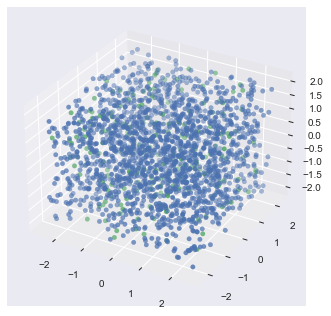

pts shape (2000, 4)


In [5]:
dataset = TestcaseDataset()
pts = dataset.pts # total samples ( train + test )

X_hifi = dataset.X_hifi
Y_hifi = dataset.Y_hifi
X_test = dataset.X_test
Y_test = dataset.Y_test
hifi_dataset = dataset.hifi_dataset
test_dataset = dataset.test_dataset


print("Shape of high fidelity X and y: ",X_hifi.shape, Y_hifi.shape)
print("Shape of test set      X and y: ",X_test.shape, Y_test.shape)
# Create data loaders
hifi_dataloader = DataLoader(hifi_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_hifi[:, 0],X_hifi[:, 1],X_hifi[:, 2])
ax.scatter(X_test[:, 0],X_test[:, 1],X_test[:, 2])

plt.show()
print('pts shape',pts.shape)

### High Fidelity Model initilization

In [6]:
# Define hyperparameters
n_samples, n_features = X_hifi.shape
input_size = n_features
hidden_size = 128
output_size = 1
learning_rate = 1e-3
# Define the neural network model (input, hidden, output size)
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(NeuralNet, self).__init__()
        # Define layers
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        #out = self.sigmoid(out)
        return out

In [29]:
nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
print(nn_model)

# Construct loss and optmizer 
criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module

# In a single training epoch, the model makes predictions on the training dataset (fed to it in batches)
# and backpropagates the prediction error to update the model’s parameters

# Training loop:
#  - forward pass: compute predictions
#  - backward pass: gradients
#  - update weights
num_epochs = 500 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
for epoch in range(num_epochs):
    size = len(hifi_dataloader.dataset)
    nn_model.train()
    for batch, (X, y) in enumerate(hifi_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn_model(X)         # prediction: forward pass
        loss = criterion(pred, y) # loss

        # Backpropagation
        optimizer.zero_grad()   # clears old gradients from the last step
        loss.backward()         # gradients: backward pass
        optimizer.step()        # update weights

    if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {num_epochs}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")
# Test       
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct, num_samples = 0, 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = nn_model(X)
        test_loss += criterion(pred, y).item()
        num_samples += y.shape[0]
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
acc = 100.0 * correct / num_samples
print(f"Test Error -> Test loss: {test_loss:>8f} \n") # Acc: {acc:>8f}

def optim_point(new_point, model):
    hidden_size, learning_rate = new_point.squeeze().numpy()
    
    # Define the neural network model (input, hidden, output size)
    class NeuralNet(nn.Module):
        def __init__(self,input_size,hidden_size,output_size):
            super(NeuralNet, self).__init__()
            # Define layers
            self.linear1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.LeakyReLU() # activation function nn.LeakyReLU()
            self.linear2 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()
        def forward(self, x):
            out = self.linear1(x)
            out = self.relu(out)
            out = self.linear2(out)
            #out = self.sigmoid(out)
            return out
    nn_model = NeuralNet(input_size,hidden_size,output_size).to(device)
    criterion = nn.MSELoss() # Mean Square Error Loss # loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) # from the optimization module
    num_epochs = 500 if not SMOKE_TEST else 5 # epoch -> forward and backward of ALL training samples
    for epoch in range(num_epochs):
        size = len(hifi_dataloader.dataset)
        nn_model.train()
        for batch, (X, y) in enumerate(hifi_dataloader):
            X, y = X.to(device), y.to(device)

           # Compute prediction error
            pred = nn_model(X)         # prediction: forward pass
            loss = criterion(pred, y) # loss

            # Backpropagation
            optimizer.zero_grad()   # clears old gradients from the last step
            loss.backward()         # gradients: backward pass
            optimizer.step()        # update weights
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} / {num_epochs}, step [{batch+1}/{len(hifi_dataloader)}] loss: {loss:.4f}")
    # Test       
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct, num_samples = 0, 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = nn_model(X)
            test_loss += criterion(pred, y).item()
            num_samples += y.shape[0]
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    return torch.Tensor([[-test_loss]])

NeuralNet(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 10 / 500, step [57/57] loss: 0.3332
Epoch 20 / 500, step [57/57] loss: 0.2048
Epoch 30 / 500, step [57/57] loss: 0.1184
Epoch 40 / 500, step [57/57] loss: 0.4541
Epoch 50 / 500, step [57/57] loss: 0.4172
Epoch 60 / 500, step [57/57] loss: 0.2585
Epoch 70 / 500, step [57/57] loss: 0.2729
Epoch 80 / 500, step [57/57] loss: 0.0337
Epoch 90 / 500, step [57/57] loss: 0.0869
Epoch 100 / 500, step [57/57] loss: 0.0526
Epoch 110 / 500, step [57/57] loss: 0.0493
Epoch 120 / 500, step [57/57] loss: 0.1766
Epoch 130 / 500, step [57/57] loss: 0.3378
Epoch 140 / 500, step [57/57] loss: 0.1782
Epoch 150 / 500, step [57/57] loss: 0.2391
Epoch 160 / 500, step [57/57] loss: 0.0398
Epoch 170 / 500, step [57/57] loss: 0.0738
Epoch 180 / 500, step [57/57] loss: 0.1616
Epoch 190 / 500, step [57/57] 

### Surrogate Model Initialization

In [8]:
def initialize_model(X_lofi, Y_lofi):
  X_lofi, Y_lofi = X_lofi.to(device), Y_lofi.to(device)
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  single_model = SingleTaskGP(X_lofi, Y_lofi)
  #single_model = ExactGPModel(X_lofi.squeeze(), Y_lofi.squeeze(), likelihood)
  
  mll = ExactMarginalLogLikelihood(likelihood, single_model) # OTHER LIKELIHOOD ?
  return mll, single_model

Define a helper function that performs the essential BO step

In [9]:
X_lofi = torch.Tensor([[hidden_size, learning_rate]])
Y_lofi = torch.Tensor([[-test_loss]])

bounds = torch.Tensor([[4, 1e-3], [256, 1e-1]])
best_obs_value = -test_loss

def get_next_points(single_model, n_points=1, acqf_name="EI"):

  NUM_RESTARTS = 10 if not SMOKE_TEST else 2
  RAW_SAMPLES = 512 if not SMOKE_TEST else 4
  NUM_FANTASIES = 128 if not SMOKE_TEST else 4

  sampler = SobolQMCNormalSampler(512)

  if acqf_name == "qNEI":
    acqf_name  = qNoisyExpectedImprovement(model = single_model, X_baseline = X_lofi, sampler=sampler )
  elif acqf_name == "qKG" :
    acqf_name  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
  elif acqf_name == "EI":
    acqf_name  = ExpectedImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "qEI":
    acqf_name  = qExpectedImprovement( model = single_model, best_f = best_obs_value, sampler=sampler )
  elif acqf_name == "PI":
    acqf_name  = ProbabilityOfImprovement( model = single_model, best_f = best_obs_value )
  elif acqf_name == "UCB":
    acqf_name  = UpperConfidenceBound(model = single_model, beta=0.3)
  elif acqf_name == "qKG_proper" :
    qKG  = qKnowledgeGradient(model = single_model, num_fantasies=NUM_FANTASIES)
    argmax_pmean, max_pmean = optimize_acqf(
      acq_function=PosteriorMean(single_model), 
      bounds=bounds,
      q=1,
      num_restarts=10 if not SMOKE_TEST else 2,
      raw_samples=1024 if not SMOKE_TEST else 4,
    )
    acqf_name = qKnowledgeGradient(
      single_model,
      num_fantasies=NUM_FANTASIES,
      sampler=qKG.sampler,
      current_value=max_pmean,
    )
  else:
    raise RuntimeError("Unknown acquisition function name!")
 
  with manual_seed(1234):
    candidates, acq_value = optimize_acqf(
        acq_function=acqf_name, 
        bounds=bounds,
        q=n_points,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES
    )
  return candidates

### Perform a few steps of multi-fidelity BO

In [10]:
N_ITER = 3 if not SMOKE_TEST else 1

for iter in range(N_ITER):
   mll, gp_model = initialize_model(X_lofi, Y_lofi)
   fit_gpytorch_mll(mll)
   new_X = get_next_points(gp_model, n_points=1)  
   predicted_optimal_obj = optim_point(new_X, nn_model) 
   print(f"Iter {iter+1}/{N_ITER} - next points: {new_X}\n pred objectives: {predicted_optimal_obj}")
   X_lofi = torch.cat([X_lofi, new_X ])
   Y_lofi = torch.cat([Y_lofi, predicted_optimal_obj])
   best_obs_value = max(best_obs_value,Y_lofi.max())

Epoch 10 / 500, step [57/57] loss: 0.3565
Epoch 20 / 500, step [57/57] loss: 0.1321
Epoch 30 / 500, step [57/57] loss: 0.1277
Epoch 40 / 500, step [57/57] loss: 0.1581
Epoch 50 / 500, step [57/57] loss: 0.3139
Epoch 60 / 500, step [57/57] loss: 0.0262
Epoch 70 / 500, step [57/57] loss: 0.1051
Epoch 80 / 500, step [57/57] loss: 0.1360
Epoch 90 / 500, step [57/57] loss: 0.1566
Epoch 100 / 500, step [57/57] loss: 0.3484
Epoch 110 / 500, step [57/57] loss: 0.0708
Epoch 120 / 500, step [57/57] loss: 0.4147
Epoch 130 / 500, step [57/57] loss: 0.5443
Epoch 140 / 500, step [57/57] loss: 0.1070
Epoch 150 / 500, step [57/57] loss: 0.2519
Epoch 160 / 500, step [57/57] loss: 0.2046
Epoch 170 / 500, step [57/57] loss: 0.1447
Epoch 180 / 500, step [57/57] loss: 0.2148
Epoch 190 / 500, step [57/57] loss: 0.1394
Epoch 200 / 500, step [57/57] loss: 0.0518
Epoch 210 / 500, step [57/57] loss: 0.1061
Epoch 220 / 500, step [57/57] loss: 0.1536
Epoch 230 / 500, step [57/57] loss: 0.0598
Epoch 240 / 500, ste

In [ ]:
fig = plt.figure(figsize=(21, 9))
Y_pred = pred(X_test, nn_model)
for alpha in range(4):
    
    ax = fig.add_subplot(2, 2, alpha+1)
    ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(),label = 'target')
    ax.scatter(X_test[:,alpha].numpy(), Y_pred.numpy(),label = 'predicted')
    plt.legend(loc="lower left")
plt.show()

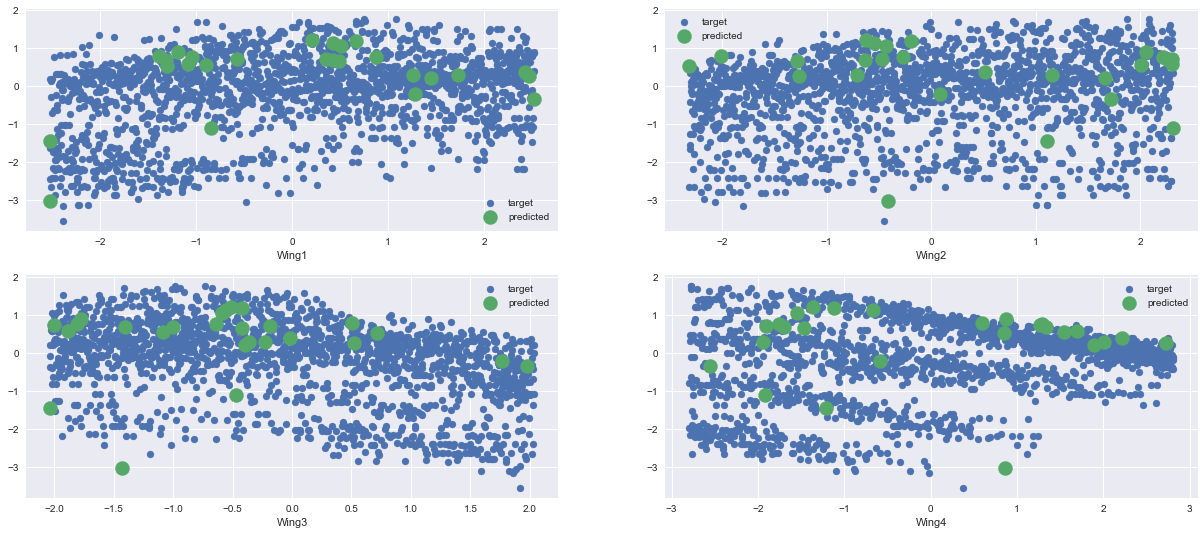

In [85]:
def pred(new_point, model):
    with torch.no_grad():
            pred_point = model(new_point)
    return pred_point

fig = plt.figure(figsize=(21, 9))
for alpha in range(4):
    ax = fig.add_subplot(2, 2, alpha+1)
    ax.scatter(X_hifi[:,alpha].numpy(), Y_hifi.numpy(),label = 'target')
    ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(),s=200,label = 'predicted')
    plt.legend()
    plt.xlabel(f"Wing{alpha+1}")
plt.show()

In [63]:
# Define the Kernel of Gaussian Process
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self,X_train, Y_train,likelihood):
        super(ExactGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

Wing1 - Iter 100/1000 - Loss: 1.19486 LenghtParam 0.64837
Wing1 - Iter 200/1000 - Loss: 1.17932 LenghtParam 0.61744
Wing1 - Iter 300/1000 - Loss: 1.16513 LenghtParam 0.60100
Wing1 - Iter 400/1000 - Loss: 1.15211 LenghtParam 0.59440
Wing1 - Iter 500/1000 - Loss: 1.14027 LenghtParam 0.59281
Wing1 - Iter 600/1000 - Loss: 1.12969 LenghtParam 0.59307
Wing1 - Iter 700/1000 - Loss: 1.12044 LenghtParam 0.59365
Wing1 - Iter 800/1000 - Loss: 1.11256 LenghtParam 0.59405
Wing1 - Iter 900/1000 - Loss: 1.10602 LenghtParam 0.59417
Wing1 - Iter 1000/1000 - Loss: 1.10078 LenghtParam 0.59406


Wing2 - Iter 100/1000 - Loss: 1.49882 LenghtParam 0.74248
Wing2 - Iter 200/1000 - Loss: 1.48215 LenghtParam 0.79097
Wing2 - Iter 300/1000 - Loss: 1.46998 LenghtParam 0.83825
Wing2 - Iter 400/1000 - Loss: 1.46088 LenghtParam 0.88441
Wing2 - Iter 500/1000 - Loss: 1.45381 LenghtParam 0.92934
Wing2 - Iter 600/1000 - Loss: 1.44805 LenghtParam 0.97287
Wing2 - Iter 700/1000 - Loss: 1.44314 LenghtParam 1.01476
Wing2 - Ite

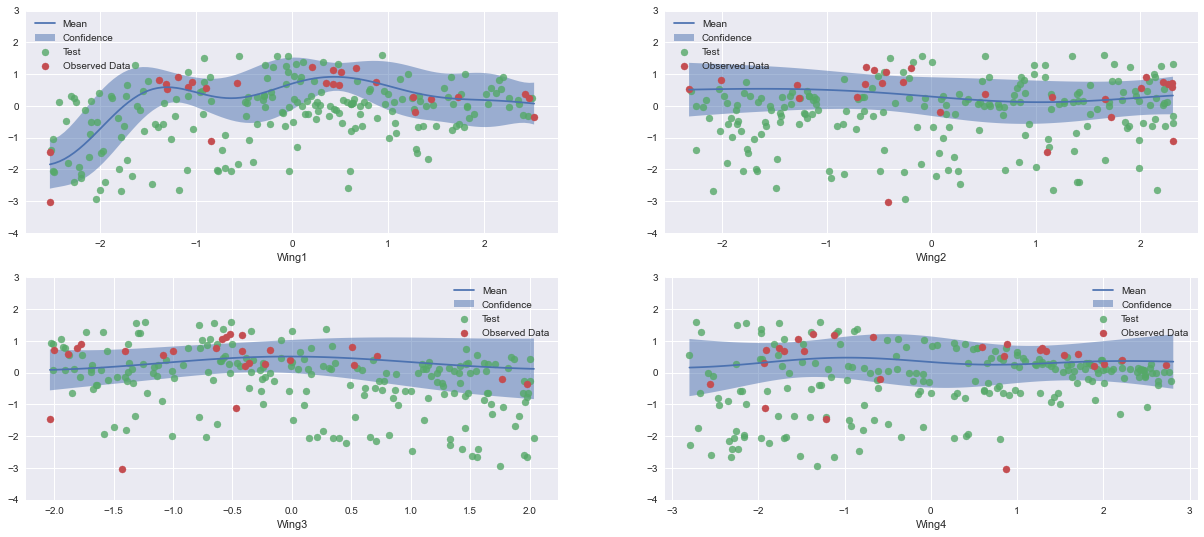

In [87]:
fig = plt.figure(figsize=(21, 9))
for alpha in range(4):
# FIT THE MODEL
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # Define the model
    #gp_model = SingleTaskGP(X_lofi[2:,alpha].unsqueeze(-1) , Y_lofi[2:], likelihood = likelihood  )
    gp_model = ExactGPModel(X_lofi[2:,alpha] , Y_lofi[2:].squeeze(), likelihood)
    # Find optimal model hyperparameters
    gp_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(gp_model.parameters(),lr=1e-3) # Use the adam optimizer  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model) # "Loss" for GPs - the marginal log likelihood
    #mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model) # "Loss" for GPs - LOO Pseudo likelihood

    training_iter  = 1000 if not SMOKE_TEST else 4
    for i in range(training_iter):
        optimizer.zero_grad()    # Zero gradients from previous iteration
        output = gp_model(X_lofi[2:,alpha])        # Output from model
        loss = -mll(output, Y_lofi[2:].squeeze())     # compute loss and backprop gradients
        loss.backward()
        if (i+1) % 100 == 0:
            print(f'Wing{alpha+1} - Iter {i + 1}/{training_iter} - Loss: {loss.item():.5f} LenghtParam {gp_model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0]:.5f}')
        optimizer.step()
    print('\n')
    
    gp_model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(X_hifi[:,alpha].min(), X_hifi[:,alpha].max(), 100)
        observed_pred = (gp_model(test_x ))      # Make predictions by feeding model through likelihood
        ax = fig.add_subplot(2, 2, alpha+1)      # Initialize plot
        lower, upper = observed_pred.confidence_region()     # Get upper and lower confidence bounds
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), label = 'Mean')     # Plot predictive means as blue line
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label = 'Confidence')  # Shade between the lower and upper confidence bounds
        ax.scatter(X_test[:,alpha].numpy(), Y_test.numpy(), alpha=0.8, label = 'Test')
        ax.scatter(X_lofi[:,alpha].numpy(), Y_lofi.numpy(), s=50,label = 'Observed Data')
        ax.set_ylim([-4,3])
        plt.xlabel(f"Wing{alpha+1}")
        ax.legend()
    # DECREASE VARIANCE
plt.show()